# Predicciones con algoritmos de regresion

Ahora que vimos un poco sobre el comportamiento de los juegos. Con ciertos parametros que definimos, como:

- Minimo tener 1000 reseñas
- Una secuela se considera exitosa en conparacion a el juego base si esta lo supera en cantidad de reseñas positivas. Y no en el porcentaje total de reseñas positivas

Nos sentraremos en ver como se vincula las secuelas exitosas, con las otras variables que traen. como **precio**, **horas de juego** y otras cosas.
Ademas que tambien repetiremos esto mismo pero haciendo que las secuelas exitosas, se consideran asi, solo si el porcentaje total de reseñas positivas sea mayor a la original.

***

**Cargamos las librerias**

In [145]:
# Librerias a ocupar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import json
import re
import ast
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [146]:
# Abro los csv para despues combinar las columnas que me interesan

with open("data/df_limpio_sin_outlier_resenas.csv", "r", encoding="utf-8") as f:
    df_limpio_sin_outlier = pd.read_csv(f)

with open("data/games_march2025_cleaned.csv", "r", encoding="utf-8") as f:
    df_sucio = pd.read_csv(f)

In [147]:
df_sucio[["name","metacritic_score"]].sample(5)

,name,metacritic_score
12203,Giraffe Town,0
41436,Make Route: Escape the police,0
21009,闲侠江湖,0
82379,DON'T WAKE THE NIGHT,0
7726,Alien: Rogue Incursion,0


In [148]:
# Lo mismo pero con el df_sucio, pero veo en especifico las columnas
df_sucio.columns

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'discount',
       'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total',
       'pct_pos_recent', 'num_reviews_recent'],
      dtype='object')

In [149]:
df_limpio_sin_outlier.head()

,Franquicia_Base,Secuela_Nombre,Secuela_Año,Secuela_Reseñas_Positivas,Secuela_Reseñas_Negativas,Secuela_Pct_Positivo,Original_Nombre,Original_Año,Original_Reseñas_Positivas,Original_Reseñas_Negativas,Original_Pct_Positivo,Años_Diferencia,Cambio_Pct_Calidad,Ratio_Popularidad_vs_Original
0,12 labours of hercules,12 Labours of Hercules II: The Cretan Bull,2015,1867,208,90,12 Labours of Hercules,2015,2814,192,93,0,-3,69.03
1,9nine,9-nine-:Episode 2,2019,1491,23,98,9-nine-:Episode 1,2019,1461,73,95,0,3,98.70
2,9nine,9-nine-:Episode 4,2021,1089,20,98,9-nine-:Episode 1,2019,1461,73,95,2,3,72.29
3,a plague tale,A Plague Tale: Requiem,2022,17807,1721,91,A Plague Tale: Innocence,2019,58010,4066,93,3,-2,31.46
4,a space for the unbound,A Space for the Unbound,2023,5674,140,97,A Space For The Unbound - Prologue,2020,1276,24,98,3,-1,447.23


***
**Estaremos trabajando con la perspectiva del programador y corporativa pera ver si un juego es un fracaso o exito y el por que de esto.**

Hago un merge que uno los dos data frame para tener mas columnas a comparar en la regresion. (Esto se puede ir modificando en el transcurso de la investigacion)

In [150]:
# Hago una nueva limpieza para quedarme con las columnas que me interesan, ademas que agrego unas columnas importantes para la regresion

# Hago columnas de boleanos dependiendo si el punto de vista es corporativo o de programador
volumen_original = df_limpio_sin_outlier['Original_Reseñas_Positivas'] + df_limpio_sin_outlier['Original_Reseñas_Negativas']
volumen_secuela = df_limpio_sin_outlier['Secuela_Reseñas_Positivas'] + df_limpio_sin_outlier['Secuela_Reseñas_Negativas']

# Esta es la columna con vision de exito corporativo
df_limpio_sin_outlier['Exito_Corporativo'] = volumen_secuela >= volumen_original

# Esta es la columna con vision de exito programador
df_limpio_sin_outlier['Exito_Programador'] = df_limpio_sin_outlier['Secuela_Pct_Positivo'] >= df_limpio_sin_outlier['Original_Pct_Positivo']

# Hago que df_sucio solo se quede con las columnas que me interesan
df_sucio = df_sucio[['name', 'price', "dlc_count", "supported_languages","genres", "developers", "publishers",]]

# Uno los dos dataframe con la columna name y Secuela_Nombre
df_limpio_sin_outlier = pd.merge(df_limpio_sin_outlier, df_sucio, left_on='Secuela_Nombre', right_on='name', how='left')

# Cambio nombre de la columna developers para que se entienda mejor
df_limpio_sin_outlier = df_limpio_sin_outlier.rename(columns={'developers': 'developers_Secuela', "publishers" : "publishers_Secuela"})

In [151]:
df_limpio_sin_outlier.head()

,Franquicia_Base,Secuela_Nombre,Secuela_Año,Secuela_Reseñas_Positivas,Secuela_Reseñas_Negativas,Secuela_Pct_Positivo,Original_Nombre,Original_Año,Original_Reseñas_Positivas,Original_Reseñas_Negativas,...,Ratio_Popularidad_vs_Original,Exito_Corporativo,Exito_Programador,name,price,dlc_count,supported_languages,genres,developers_Secuela,publishers_Secuela
0,12 labours of hercules,12 Labours of Hercules II: The Cretan Bull,2015,1867,208,90,12 Labours of Hercules,2015,2814,192,...,69.03,False,False,12 Labours of Hercules II: The Cretan Bull,2.99,0,"['English', 'French', 'Italian', 'German', 'Sp...","['Casual', 'Strategy']","['Jetdogs Studios', 'Zoom Out Games']",['Jetdogs Studios']
1,9nine,9-nine-:Episode 2,2019,1491,23,98,9-nine-:Episode 1,2019,1461,73,...,98.70,False,True,9-nine-:Episode 2,19.99,0,"['English', 'Japanese', 'Traditional Chinese']","['Action', 'Casual', 'Simulation']",['PALETTE'],['Sekai Project']
2,9nine,9-nine-:Episode 4,2021,1089,20,98,9-nine-:Episode 1,2019,1461,73,...,72.29,False,True,9-nine-:Episode 4,9.99,0,"['English', 'Japanese', 'Traditional Chinese']",['Casual'],['PALETTE'],['Sekai Project']
3,a plague tale,A Plague Tale: Requiem,2022,17807,1721,91,A Plague Tale: Innocence,2019,58010,4066,...,31.46,False,False,A Plague Tale: Requiem,19.99,1,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Adventure']",['Asobo Studio'],['Focus Entertainment']
4,a space for the unbound,A Space for the Unbound,2023,5674,140,97,A Space For The Unbound - Prologue,2020,1276,24,...,447.23,True,False,A Space for the Unbound,19.99,2,"['English', 'Japanese', 'Korean', 'Portuguese ...","['Adventure', 'Indie']",['Mojiken'],['Toge Productions']


In [152]:
# Guardo este data frame temporalmente
with open("data/df_regresion_completo.csv", "w", encoding="utf-8") as f:
    df_limpio_sin_outlier.to_csv(f, index=False)

***
### Empezando el proceso de ver las posibles causas de que un juego sea un fracaso

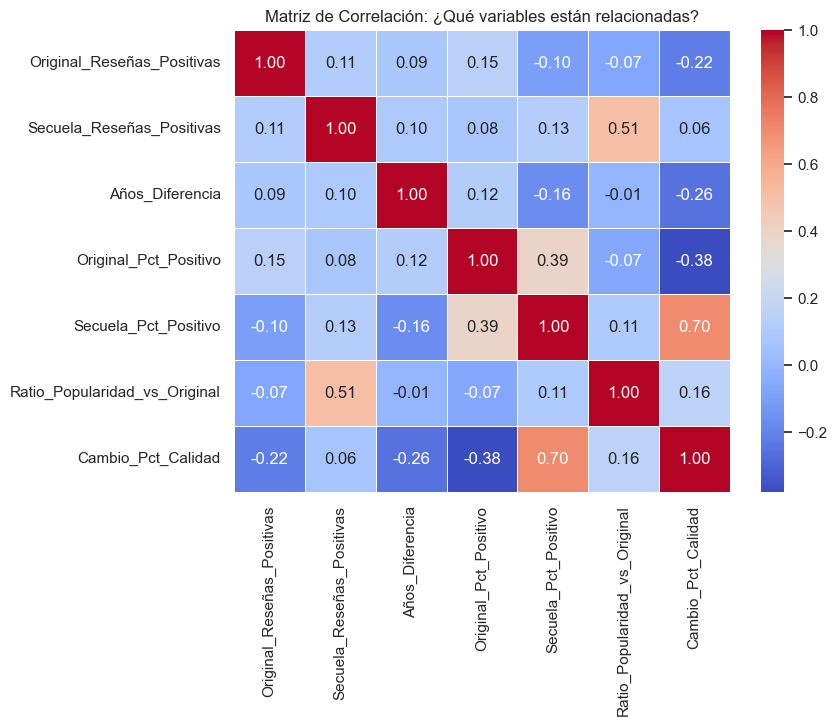

In [153]:
cols_interes = ['Original_Reseñas_Positivas', 'Secuela_Reseñas_Positivas', 
                'Años_Diferencia', 
                'Original_Pct_Positivo', 'Secuela_Pct_Positivo',  
                'Ratio_Popularidad_vs_Original', 
                'Cambio_Pct_Calidad']

corr_matrix = df_limpio_sin_outlier[cols_interes].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación: ¿Qué variables están relacionadas?')
plt.show()

La variable del tiempo de salida de la primera entrega con la secuela es una de las que perjudica bastante. Posiblemente por la perdida del Hype. En la variable que mas perjudica a las secuelas a que estas sean un fracaso esta el porcentaje positivo total del juego original. Que el primer juego haya sido una obra de arte, hace que haya mucha estima en el siguiente juego.
***
## Empiezo a ver los posibles recursos de regresion que puedo ocupar con este data frame y sus columans

### Clasificacion KNN con la vision corporativa (Exito si tiene mejores ventas que el original)


Precisión del modelo: 56.76%


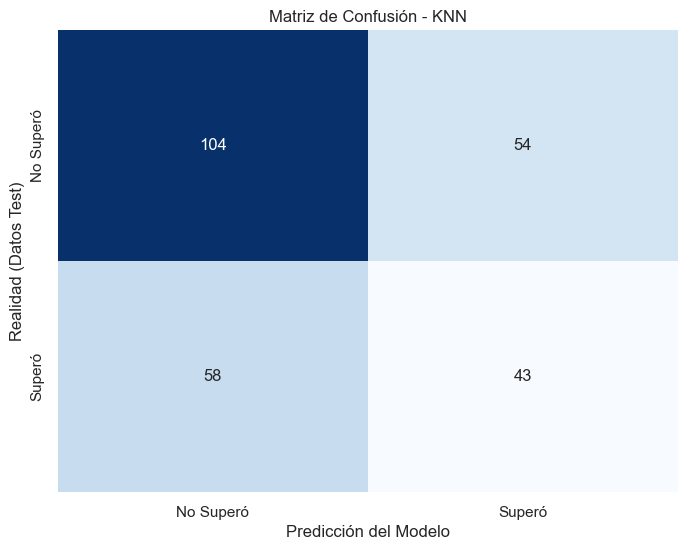

In [154]:
df = pd.read_csv('data/df_regresion_completo.csv')

# La columna de boleano la comvierto a 1 y 0
y = df['Exito_Corporativo'].astype(int)

# Con esto puedo procesar de mejor manera las columans que estan en listas
def procesar_columna_lista(df, nombre_col, top_n=None):
    # Cambio el tipo de variable
    lista_limpia = df[nombre_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    
    # Contar cuantos elementos hay
    todos_items = [item for sublist in lista_limpia for item in sublist]
    
    # Seleccionar el que mas se repite
    if top_n:
        top_items = [item for item, count in Counter(todos_items).most_common(top_n)]
    else:
        top_items = sorted(list(set(todos_items)))
    
    # Crear un df de dummies
    datos_dummy = pd.DataFrame()
    for item in top_items:
        # quitamos los nombres raros
        nombre_limpio = f"{nombre_col}_{item.replace(' ', '_').replace('-', '_')}"
        datos_dummy[nombre_limpio] = lista_limpia.apply(lambda x: 1 if item in x else 0)
    
    return datos_dummy

# Con la funcion hecha la aplicamos 
X_genres = procesar_columna_lista(df, 'genres', top_n=None)        # Todos los géneros
X_langs  = procesar_columna_lista(df, 'supported_languages', top_n=15) # Top 15 idiomas
X_devs   = procesar_columna_lista(df, 'developers_Secuela', top_n=10)      # Top 10 devs (evita ruido)
X_pubs   = procesar_columna_lista(df, 'publishers_Secuela', top_n=10)      # Top 10 publishers

# Variables en la base X, independientes
X_base = df[['Años_Diferencia', 'price', 'dlc_count']]

# Hacer un concat de todas las variables independientes
X = pd.concat([X_base, X_genres, X_langs, X_devs, X_pubs], axis=1)

# Entrenar el modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# que sea 70-30
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42
)

# Aqui activamos el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Hacemos la prediccion
y_pred = knn.predict(X_test)

# Imprimimos la presicion para que sea comodo de ver
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2%}")

# Graficamos la matriz de confusion para ver el comportamiento y ver los errores que comete
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Superó', 'Superó'],
            yticklabels=['No Superó', 'Superó'])

plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Datos Test)')
plt.title('Matriz de Confusión - KNN')
plt.show()

Precisión del modelo: 55.60%


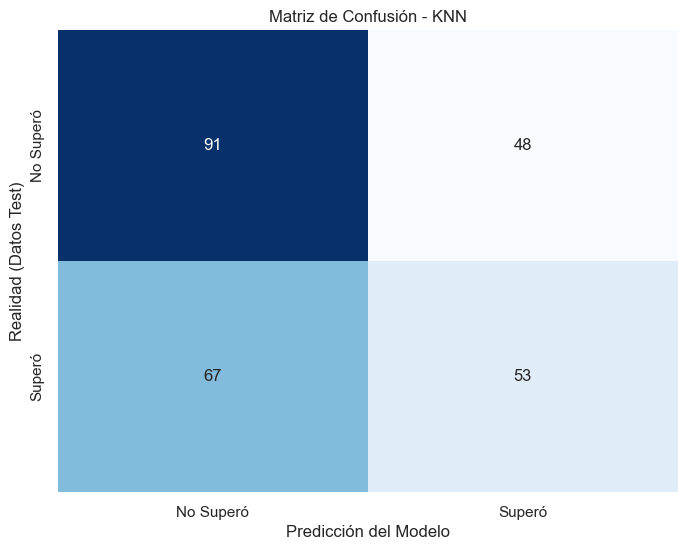

In [155]:
df = pd.read_csv('data/df_regresion_completo.csv')

# La columna de boleano la comvierto a 1 y 0
y = df['Exito_Programador'].astype(int)

# Con esto puedo procesar de mejor manera las columans que estan en listas
def procesar_columna_lista(df, nombre_col, top_n=None):
    # Cambio el tipo de variable
    lista_limpia = df[nombre_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    
    # Contar cuantos elementos hay
    todos_items = [item for sublist in lista_limpia for item in sublist]
    
    # Seleccionar el que mas se repite
    if top_n:
        top_items = [item for item, count in Counter(todos_items).most_common(top_n)]
    else:
        top_items = sorted(list(set(todos_items)))
    
    # Crear un df de dummies
    datos_dummy = pd.DataFrame()
    for item in top_items:
        # quitamos los nombres raros
        nombre_limpio = f"{nombre_col}_{item.replace(' ', '_').replace('-', '_')}"
        datos_dummy[nombre_limpio] = lista_limpia.apply(lambda x: 1 if item in x else 0)
    
    return datos_dummy

# Con la funcion hecha la aplicamos 
X_genres = procesar_columna_lista(df, 'genres', top_n=None)        # Todos los géneros
X_langs  = procesar_columna_lista(df, 'supported_languages', top_n=15) # Top 15 idiomas
X_devs   = procesar_columna_lista(df, 'developers_Secuela', top_n=10)      # Top 10 devs (evita ruido)
X_pubs   = procesar_columna_lista(df, 'publishers_Secuela', top_n=10)      # Top 10 publishers

# Variables en la base X, independientes
X_base = df[['Años_Diferencia', 'price', 'dlc_count']]

# Hacer un concat de todas las variables independientes
X = pd.concat([X_base, X_genres, X_langs, X_devs, X_pubs], axis=1)

# Entrenar el modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# que sea 70-30
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42
)

# Aqui activamos el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Hacemos la prediccion
y_pred = knn.predict(X_test)

# Imprimimos la presicion para que sea comodo de ver
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2%}")

# Graficamos la matriz de confusion para ver el comportamiento y ver los errores que comete
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Superó', 'Superó'],
            yticklabels=['No Superó', 'Superó'])

plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Datos Test)')
plt.title('Matriz de Confusión - KNN')
plt.show()

### **Este sistema de regresion no nos sirve**
Este modelo para predecir no nos dice nada. Es como una caja negra. Funciona pero no saber porque. En este caso no sabes que esta predicion y a que se refiere con la precicion

***
## Random Forest
La regresion y clasificacion KNN no me sirve mucho para ver que si tiene un modelo predicotr. Con el grafico de confusion, me dice que tiene bastante exito en predecir si un juego sera un fracaso o no. Pero no me dice cuales son las variables que afectan eso. Ademas que tampoco se puede plasmar un modelo predictor para este caso. Asique mejor pruebo con otro tipo de regresion. **La random forest**, Con este tipo de regresion podre ver cuales son las variables que afectan a que una secuela tenga mas probabilidades de fracasar o tener exito.

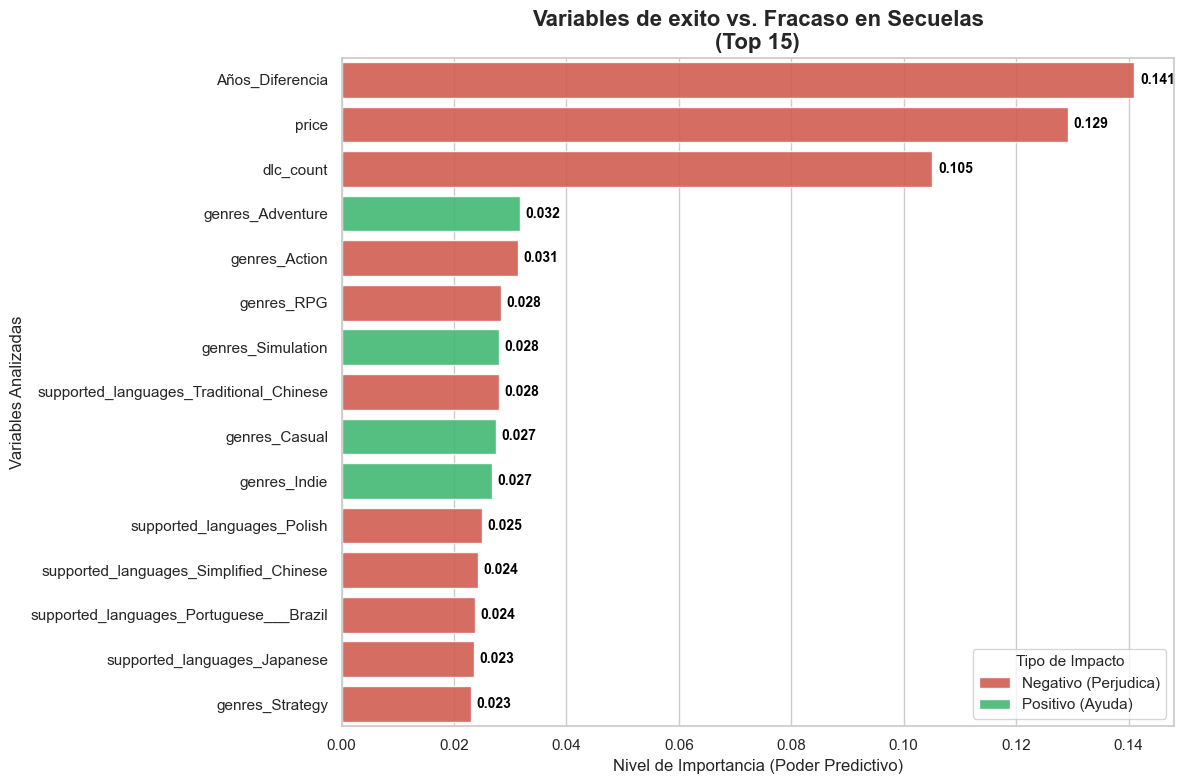

In [167]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Hago una correlacion
importancias = rf.feature_importances_

# Esto optimiza los tiempos creo
correlaciones = X.corrwith(pd.Series(y, index=X.index))

# Crear el DataFrame para el gráfico
df_grafico = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias,
    'Correlacion': correlaciones.values
})


df_grafico['Impacto'] = df_grafico['Correlacion'].apply(lambda x: 'Positivo (Ayuda)' if x > 0 else 'Negativo (Perjudica)')

# Tomo los 15 mas altos
df_grafico = df_grafico.sort_values(by='Importancia', ascending=False).head(15)

# Grafico los resultados
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# colores
paleta_colores = {'Positivo (Ayuda)': '#2ecc71', 'Negativo (Perjudica)': '#e74c3c'}

# modifico las variables
ax = sns.barplot(
    data=df_grafico,
    x='Importancia',
    y='Variable',
    hue='Impacto',
    palette=paleta_colores,
    dodge=False,
    alpha=0.9
)

# Añadir los valores numéricos al final de las barras
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.001,
                p.get_y() + p.get_height() / 2,
                f'{width:.3f}',
                ha = 'left', va = 'center',
                fontsize=10, color='black', fontweight='bold')

# titulos
plt.title('Variables de exito vs. Fracaso en Secuelas\n(Top 15)', fontsize=16, fontweight='bold')
plt.xlabel('Nivel de Importancia (Poder Predictivo)', fontsize=12)
plt.ylabel('Variables Analizadas', fontsize=12)

plt.legend(title='Tipo de Impacto', title_fontsize='11', loc='lower right')

plt.tight_layout()
plt.show()

# Conclusion:
Este modelo de Random Forest demuestra que el Éxito Comercial de una secuela no es meritocrático. No gana el mejor juego (las variables tienen poco peso). Por lo visto en las gana el juego que sale más rapido **(Años_Diferencia bajo)** y logra movilizar a su base de fans que creo al hacer el primer juego anterior **(Ratio_Popularidad alto)**. La calidad del producto es, irónicamente, un factor secundario para las ventas.

Con poca investigacion ya nos podemos dar cuenta lo aleatorio que puede ser esta industria del entretenimiento. y lo poco que importa las variables como la calidad del contenido u otros factores que parecen importantes pero no lo son.
***

# Nuevos contenido

Ya viendoo cosas del EDA o de machine learning, estare experimentando con algunas columnas en especifico para poder responder las preguntas de investigacion.

Asique ahora veremos como los developers pueden afectar a las secuelos o no.

In [157]:
df_limpio_sin_outlier.head()

,Franquicia_Base,Secuela_Nombre,Secuela_Año,Secuela_Reseñas_Positivas,Secuela_Reseñas_Negativas,Secuela_Pct_Positivo,Original_Nombre,Original_Año,Original_Reseñas_Positivas,Original_Reseñas_Negativas,...,Ratio_Popularidad_vs_Original,Exito_Corporativo,Exito_Programador,name,price,dlc_count,supported_languages,genres,developers_Secuela,publishers_Secuela
0,12 labours of hercules,12 Labours of Hercules II: The Cretan Bull,2015,1867,208,90,12 Labours of Hercules,2015,2814,192,...,69.03,False,False,12 Labours of Hercules II: The Cretan Bull,2.99,0,"['English', 'French', 'Italian', 'German', 'Sp...","['Casual', 'Strategy']","['Jetdogs Studios', 'Zoom Out Games']",['Jetdogs Studios']
1,9nine,9-nine-:Episode 2,2019,1491,23,98,9-nine-:Episode 1,2019,1461,73,...,98.70,False,True,9-nine-:Episode 2,19.99,0,"['English', 'Japanese', 'Traditional Chinese']","['Action', 'Casual', 'Simulation']",['PALETTE'],['Sekai Project']
2,9nine,9-nine-:Episode 4,2021,1089,20,98,9-nine-:Episode 1,2019,1461,73,...,72.29,False,True,9-nine-:Episode 4,9.99,0,"['English', 'Japanese', 'Traditional Chinese']",['Casual'],['PALETTE'],['Sekai Project']
3,a plague tale,A Plague Tale: Requiem,2022,17807,1721,91,A Plague Tale: Innocence,2019,58010,4066,...,31.46,False,False,A Plague Tale: Requiem,19.99,1,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Adventure']",['Asobo Studio'],['Focus Entertainment']
4,a space for the unbound,A Space for the Unbound,2023,5674,140,97,A Space For The Unbound - Prologue,2020,1276,24,...,447.23,True,False,A Space for the Unbound,19.99,2,"['English', 'Japanese', 'Korean', 'Portuguese ...","['Adventure', 'Indie']",['Mojiken'],['Toge Productions']


**Vamos hace una nueva columna que tenga los developers de la original**

In [158]:
# Hago que df_sucio solo se quede con las columnas que me interesan
df_sucio1 = df_sucio[['name', "developers"]]

# unimos con merch el df_sucio1 con el limpio con la columna clave de Original_Nombre
df = pd.merge(df_limpio_sin_outlier, df_sucio1, left_on='Original_Nombre', right_on='name', how='left')

# Cambio nombre de la columna developers para que se entienda mejor
df = df.rename(columns={'developers': 'developers_Originales',})


# Me quedo con las columnas que quiero no mas 
df = df[['Secuela_Nombre', 'Secuela_Pct_Positivo', 'Original_Nombre', 'Original_Pct_Positivo',
                                               'Cambio_Pct_Calidad', 'developers_Secuela', 'developers_Originales']]


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Secuela_Nombre         1023 non-null   object
 1   Secuela_Pct_Positivo   1023 non-null   int64 
 2   Original_Nombre        1023 non-null   object
 3   Original_Pct_Positivo  1023 non-null   int64 
 4   Cambio_Pct_Calidad     1023 non-null   int64 
 5   developers_Secuela     1023 non-null   object
 6   developers_Originales  1023 non-null   object
dtypes: int64(3), object(4)
memory usage: 56.1+ KB


In [160]:
df.sample(10)

,Secuela_Nombre,Secuela_Pct_Positivo,Original_Nombre,Original_Pct_Positivo,Cambio_Pct_Calidad,developers_Secuela,developers_Originales
612,River City Girls 2,85,River City Girls,84,1,['WayForward'],['WayForward']
11,Age of Mythology: Retold,90,Age of Mythology: Extended Edition,93,-3,"[""World's Edge"", 'Forgotten Empires', 'Tantalu...","['SkyBox Labs', 'Ensemble Studios']"
990,WolfQuest: Anniversary Edition,97,WolfQuest: Classic,91,6,['eduweb'],['eduweb']
638,SCP: Nine-Tailed Fox,75,SCP: Secret Laboratory,91,-16,['Third Subdivision Studios'],['Northwood Studios']
1,9-nine-:Episode 2,98,9-nine-:Episode 1,95,3,['PALETTE'],['PALETTE']
82,Call of Duty®: Modern Warfare® 3 (2011),89,Call of Duty®: Black Ops,91,-2,"['Infinity Ward', 'Sledgehammer Games']",['Treyarch']
939,Turok 2: Seeds of Evil,92,Turok,94,-2,"['Iguana Entertainment', 'Nightdive Studios']","['Iguana Entertainment', 'Nightdive Studios']"
642,Seek Girl:Fog Ⅰ,84,Seek Girl,77,7,['DSGame'],['DSGame']
932,Train Sim World® 4,79,Train Sim World® 2020,77,2,['Dovetail Games'],['Dovetail Games']
510,Might & Magic X - Legacy,65,Might & Magic: Heroes VI,46,19,['Ubisoft'],['Blackhole']


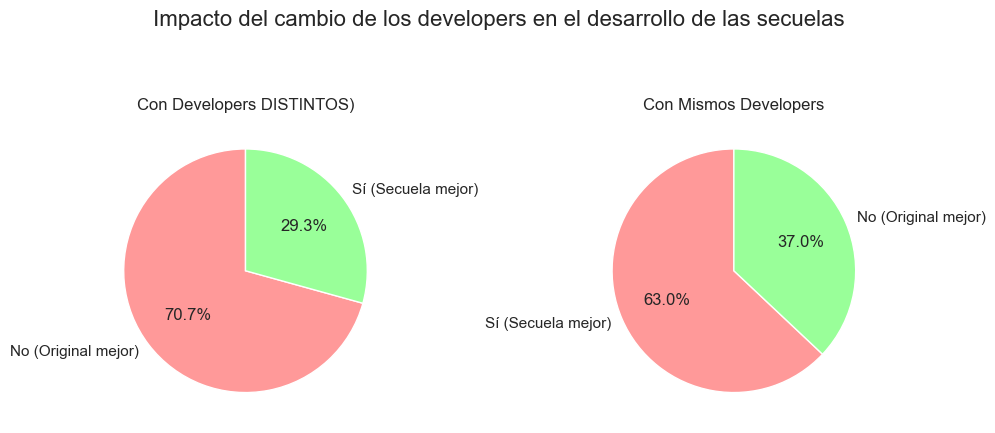

In [166]:
df_clean = df.dropna(subset=['developers_Secuela', 'developers_Originales', 'Secuela_Pct_Positivo', 'Original_Pct_Positivo']).copy()

# CONVERTIR LAS COLUMNAS DE TEXTO A LISTAS REALES
# Como vienen de un CSV/Excel, pandas las lee como strings "['DevA', 'DevB']".
# Usamos ast.literal_eval para que Python entienda que son listas.
def convertir_a_set(texto):
    try:
        # Convierte el string a lista y luego a set para comparar sin importar el orden
        return set(ast.literal_eval(texto))
    except:
        return set()

df_clean['devs_secuela_set'] = df_clean['developers_Secuela'].apply(convertir_a_set)
df_clean['devs_original_set'] = df_clean['developers_Originales'].apply(convertir_a_set)

# ETERMINAR SI CAMBIARON LOS DEVELOPERS
df_clean['cambio_dev'] = df_clean['devs_secuela_set'] != df_clean['devs_original_set']

# DEtermina la secuela
df_clean['resultado'] = df_clean.apply(
    lambda row: 'No (Original mejor)' if row['Original_Pct_Positivo'] > row['Secuela_Pct_Positivo'] else 'Sí (Secuela mejor)',
    axis=1
)

# GENERAR LOS GRÁFICOS
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Gráfico 1: Cuando SI cambiaron los developers
datos_cambio = df_clean[df_clean['cambio_dev']]['resultado'].value_counts()
if not datos_cambio.empty:
    axes[0].pie(datos_cambio, labels=datos_cambio.index, autopct='%1.1f%%', colors=['#ff9999','#99ff99'], startangle=90)
    axes[0].set_title(f'Con Developers DISTINTOS)') # \n(Total juegos: {datos_cambio.sum()}
else:
    axes[0].text(0.5, 0.5, 'Sin datos', ha='center')

# Gráfico 2: Cuando NO cambiaron los developers (Mismo equipo)
datos_mismo = df_clean[~df_clean['cambio_dev']]['resultado'].value_counts()
if not datos_mismo.empty:
    axes[1].pie(datos_mismo, labels=datos_mismo.index, autopct='%1.1f%%', colors=['#ff9999','#99ff99'], startangle=90)
    axes[1].set_title(f'Con Mismos Developers') # \n(Total juegos: {datos_mismo.sum()})
else:
    axes[1].text(0.5, 0.5, 'Sin datos', ha='center')

plt.suptitle('Impacto del cambio de los developers en el desarrollo de las secuelas', fontsize=16)
plt.tight_layout()
plt.show()
